In [89]:
import numpy as np 
import pandas as pd 

import re
import string
import nltk 
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [90]:
df = pd.read_csv("dataset/filtere_dice_jobs_dataset.csv")
df.head(2)

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7
1,https://www.dice.com/jobs/detail/Network-Engin...,Noble1,"Full Time, Direct Hire",Network Engineer Job Description A Network Eng...,Dice Id : 90884761,"Atlanta, GA",Network Engineer,1 hour ago,Telecommuting not available|Travel not required,NaN,"Cisco, DNS, HTTP, Networking, Network Engineer...",e7e326053c586bd94e59f1fd74de4a1b


In [91]:
df['employmenttype_jobstatus'] = df['employmenttype_jobstatus'].fillna('None')
data = []
data.append(df['employmenttype_jobstatus'].values.tolist())
res = []
for i in range (0,df.shape[0]):
  res.append(data[0][i])

In [92]:
def text_lowercase(text):
    return text.lower()
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [93]:
results = []
for i in range(0,df.shape[0]):
    lower_punc = text_lowercase(res[i])
    results.append(lower_punc)

In [94]:
# Print out the first rows of papers
df['text_processed_jobstatus'] =  results

In [95]:
df["combined_columns"] = df.text_processed_jobstatus + ", " + df.skills
df["combined_columns"]=df["combined_columns"].apply(lambda x:x.replace(',',''))
df.combined_columns.head(12)

0     full time Configuration Management Developer L...
1     full time direct hire Cisco DNS HTTP Networkin...
2     full time direct placement C++ Developer Devel...
3                    contract w2 contract mobile device
4             contract w2 contract AI Maya Browzwear 3D
5                  contract w2 contract .NET and C# SQl
6     contract corp-to-corp 12 months HTML JavaScrip...
7      full time full time SQL Reporting Services Suite
8     contract w2 contract B2C digital product manag...
9     contract corp-to-corp contract independent con...
10    full time full_time Access Analysis Analytical...
11    full time full_time Access Analytical Computer...
Name: combined_columns, dtype: object

In [96]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['combined_columns'])

In [97]:
X

<1563x491 sparse matrix of type '<class 'numpy.float64'>'
	with 16054 stored elements in Compressed Sparse Row format>

In [98]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=10, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [99]:
wcss=[]
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


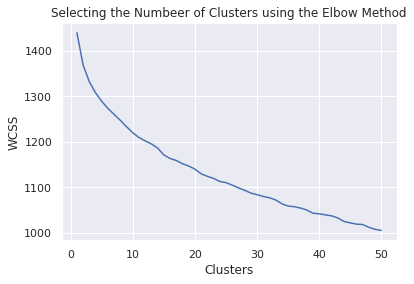

In [100]:
sns.set()
plt.plot(range(1, 51), wcss)
plt.title('Selecting the Numbeer of Clusters using the Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

In [101]:
[c for c in clusters][:10]

[3, 4, 3, 7, 7, 0, 5, 3, 7, 9]

In [102]:

from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]


In [103]:
x0

array([-0.18272443, -0.18185297, -0.20214284, ..., -0.12679819,
        0.05132155, -0.16831956])

In [104]:
# assign clusters and pca vectors to our dataframe 
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1


In [105]:
df.head(2)

,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id,text_processed_jobstatus,combined_columns,cluster,x0,x1
0,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7,full time,full time Configuration Management Developer L...,3,-0.182724,-0.066721
1,https://www.dice.com/jobs/detail/Network-Engin...,Noble1,"Full Time, Direct Hire",Network Engineer Job Description A Network Eng...,Dice Id : 90884761,"Atlanta, GA",Network Engineer,1 hour ago,Telecommuting not available|Travel not required,NaN,"Cisco, DNS, HTTP, Networking, Network Engineer...",e7e326053c586bd94e59f1fd74de4a1b,"full time, direct hire",full time direct hire Cisco DNS HTTP Networkin...,4,-0.181853,-0.133109


In [106]:

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names()# access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
        #print(terms[np.argsort(r)[1]])
get_top_keywords(20)


Cluster 0
api,programming,c2h,jquery,contract,html,web,development,vb,css,w2,developer,javascript,server,mvc,time,full,sql,asp,net

Cluster 1
budget,to,it,agile,experience,corp,sdlc,pharma,c2h,independent,12,pmp,time,full,months,w2,contract,management,manager,project

Cluster 2
system,testing,analytics,systems,c2h,agile,excel,months,project,sql,management,data,requirements,full,time,contract,w2,analysis,analyst,business

Cluster 3
android,data,vmware,aws,mysql,unix,spring,python,windows,systems,devops,j2ee,development,engineer,sql,linux,software,java,time,full

Cluster 4
tcp,w2,nexus,ip,management,firewalls,firewall,ccna,vpn,security,routers,ccnp,switches,lan,wan,time,full,engineer,network,cisco

Cluster 5
json,jsp,web,c2h,css3,months,ajax,and,time,full,java,html5,w2,contract,js,angular,jquery,css,html,javascript

Cluster 6
to,systems,working,data,strong,sql,knowledge,development,the,w2,time,full,contract,years,or,with,in,of,experience,and

Cluster 7
data,engineer,net,devops,time,full

In [107]:
# map clusters to appropriate labels 
cluster_map = {0: "Full-time+full-stack", 1: "c2h+FullTime+Project manager", 2: "W2+FullTime+Data analyst",3: "FullTime+Devops",4:"FullTime+NetworkEngineer",5:"FullTime+FrontEnd",6:"w2+FullTime+Contract+Backend",7:"c2h+FullTime+FullStack",8:"Contract+FullTime+MobileDeveloper",9:"c2h+FullTime+BusinessAnalyst"}
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

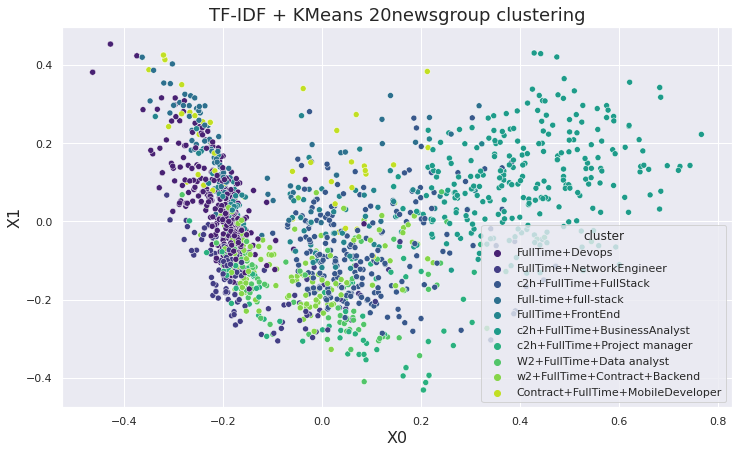

In [108]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()